## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.6, 0.3, 0.1]
redice_lr_patient = [3, 5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.60, reduce_patient: 3
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
bat

49/49 [==============================] - 2s 48ms/step - loss: 1.3395 - accuracy: 0.5322 - val_loss: 1.4846 - val_accuracy: 0.4764 - lr: 0.0010
Epoch 11/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3142 - accuracy: 0.5435 - val_loss: 1.4744 - val_accuracy: 0.4792 - lr: 0.0010
Epoch 12/25
49/49 [==============================] - 2s 49ms/step - loss: 1.2913 - accuracy: 0.5503 - val_loss: 1.4682 - val_accuracy: 0.4828 - lr: 0.0010
Epoch 13/25
49/49 [==============================] - 3s 59ms/step - loss: 1.2690 - accuracy: 0.5592 - val_loss: 1.4589 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 14/25
49/49 [==============================] - 3s 55ms/step - loss: 1.2471 - accuracy: 0.5663 - val_loss: 1.4569 - val_accuracy: 0.4893 - lr: 0.0010
Epoch 15/25
49/49 [==============================] - 2s 51ms/step - loss: 1.2279 - accuracy: 0.5744 - val_loss: 1.4541 - val_accuracy: 0.4912 - lr: 0.0010
Epoch 16/25
49/49 [==============================] - 2s 51ms/step - loss: 1.2074 -

Epoch 1/25
49/49 [==============================] - 3s 55ms/step - loss: 2.2658 - accuracy: 0.2577 - val_loss: 2.1585 - val_accuracy: 0.1765 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 2s 49ms/step - loss: 1.7696 - accuracy: 0.3823 - val_loss: 1.9987 - val_accuracy: 0.2910 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 3s 53ms/step - loss: 1.6393 - accuracy: 0.4282 - val_loss: 1.8215 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5658 - accuracy: 0.4511 - val_loss: 1.7173 - val_accuracy: 0.4122 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 51ms/step - loss: 1.5099 - accuracy: 0.4713 - val_loss: 1.6282 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4663 - accuracy: 0.4861 - val_loss: 1.5790 - val_accuracy: 0.4460 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 3s 66ms/step - loss: 1.4

Epoch 18/25
49/49 [==============================] - 2s 47ms/step - loss: 1.4133 - accuracy: 0.5087 - val_loss: 1.5691 - val_accuracy: 0.4502 - lr: 3.0000e-04
Epoch 19/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4004 - accuracy: 0.5119 - val_loss: 1.5672 - val_accuracy: 0.4516 - lr: 3.0000e-04
Epoch 20/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3879 - accuracy: 0.5184 - val_loss: 1.5597 - val_accuracy: 0.4526 - lr: 3.0000e-04
Epoch 21/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3758 - accuracy: 0.5209 - val_loss: 1.5538 - val_accuracy: 0.4571 - lr: 3.0000e-04
Epoch 22/25
49/49 [==============================] - 2s 49ms/step - loss: 1.3649 - accuracy: 0.5263 - val_loss: 1.5479 - val_accuracy: 0.4587 - lr: 3.0000e-04
Epoch 23/25
49/49 [==============================] - 2s 44ms/step - loss: 1.3534 - accuracy: 0.5306 - val_loss: 1.5416 - val_accuracy: 0.4602 - lr: 3.0000e-04
Epoch 24/25
49/49 [===========================

49/49 [==============================] - 2s 51ms/step - loss: 2.4817 - accuracy: 0.2081 - val_loss: 2.1948 - val_accuracy: 0.1667 - lr: 3.0000e-04
Epoch 2/25
49/49 [==============================] - 3s 58ms/step - loss: 2.0038 - accuracy: 0.3152 - val_loss: 2.0859 - val_accuracy: 0.2551 - lr: 3.0000e-04
Epoch 3/25
49/49 [==============================] - 2s 48ms/step - loss: 1.8511 - accuracy: 0.3557 - val_loss: 1.9767 - val_accuracy: 0.2909 - lr: 3.0000e-04
Epoch 4/25
49/49 [==============================] - 2s 48ms/step - loss: 1.7674 - accuracy: 0.3830 - val_loss: 1.8722 - val_accuracy: 0.3312 - lr: 3.0000e-04
Epoch 5/25
49/49 [==============================] - 2s 46ms/step - loss: 1.7081 - accuracy: 0.4020 - val_loss: 1.7972 - val_accuracy: 0.3567 - lr: 3.0000e-04
Epoch 6/25
49/49 [==============================] - 2s 45ms/step - loss: 1.6628 - accuracy: 0.4190 - val_loss: 1.7410 - val_accuracy: 0.3817 - lr: 3.0000e-04
Epoch 7/25
49/49 [==============================] - 2s 50ms/ste

49/49 [==============================] - 2s 50ms/step - loss: 1.4128 - accuracy: 0.5069 - val_loss: 1.5679 - val_accuracy: 0.4467 - lr: 3.0000e-04
Epoch 19/25
49/49 [==============================] - 3s 53ms/step - loss: 1.3992 - accuracy: 0.5109 - val_loss: 1.5628 - val_accuracy: 0.4497 - lr: 3.0000e-04
Epoch 20/25
49/49 [==============================] - 2s 50ms/step - loss: 1.3882 - accuracy: 0.5150 - val_loss: 1.5618 - val_accuracy: 0.4486 - lr: 3.0000e-04
Epoch 21/25
49/49 [==============================] - 2s 47ms/step - loss: 1.3750 - accuracy: 0.5194 - val_loss: 1.5541 - val_accuracy: 0.4538 - lr: 3.0000e-04
Epoch 22/25
49/49 [==============================] - 2s 50ms/step - loss: 1.3624 - accuracy: 0.5251 - val_loss: 1.5453 - val_accuracy: 0.4575 - lr: 3.0000e-04
Epoch 23/25
49/49 [==============================] - 2s 46ms/step - loss: 1.3505 - accuracy: 0.5281 - val_loss: 1.5413 - val_accuracy: 0.4577 - lr: 3.0000e-04
Epoch 24/25
49/49 [==============================] - 3s 53

49/49 [==============================] - 3s 52ms/step - loss: 1.7977 - accuracy: 0.3809 - val_loss: 2.3399 - val_accuracy: 0.1520 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 3s 53ms/step - loss: 1.4924 - accuracy: 0.4729 - val_loss: 2.0754 - val_accuracy: 0.2486 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 3s 52ms/step - loss: 1.3827 - accuracy: 0.5104 - val_loss: 1.7503 - val_accuracy: 0.3755 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 3s 51ms/step - loss: 1.2956 - accuracy: 0.5435 - val_loss: 1.8070 - val_accuracy: 0.3597 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 2s 44ms/step - loss: 1.2271 - accuracy: 0.5660 - val_loss: 1.6966 - val_accuracy: 0.4043 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 2s 51ms/step - loss: 1.1638 - accuracy: 0.5885 - val_loss: 1.8801 - val_accuracy: 0.3620 - lr: 0.0010
Epoch 7/25
49/49 [==============================] - 2s 46ms/step - loss: 1.1072 - accur

Epoch 15/25
49/49 [==============================] - 2s 43ms/step - loss: 0.9121 - accuracy: 0.6916 - val_loss: 1.4720 - val_accuracy: 0.4906 - lr: 1.2960e-04
Epoch 16/25
49/49 [==============================] - 2s 43ms/step - loss: 0.8849 - accuracy: 0.7016 - val_loss: 1.5400 - val_accuracy: 0.4770 - lr: 1.2960e-04
Epoch 17/25
49/49 [==============================] - 2s 42ms/step - loss: 0.8580 - accuracy: 0.7121 - val_loss: 1.4699 - val_accuracy: 0.4920 - lr: 1.2960e-04
Epoch 18/25
49/49 [==============================] - ETA: 0s - loss: 0.8328 - accuracy: 0.7227
Epoch 00018: ReduceLROnPlateau reducing learning rate to 7.775999838486313e-05.
49/49 [==============================] - 2s 43ms/step - loss: 0.8328 - accuracy: 0.7227 - val_loss: 1.4595 - val_accuracy: 0.5002 - lr: 1.2960e-04
Epoch 19/25
49/49 [==============================] - 2s 43ms/step - loss: 0.7902 - accuracy: 0.7396 - val_loss: 1.4255 - val_accuracy: 0.5094 - lr: 7.7760e-05
Epoch 20/25
49/49 [=======================

Epoch 1/25
49/49 [==============================] - 3s 54ms/step - loss: 1.8541 - accuracy: 0.3630 - val_loss: 2.0378 - val_accuracy: 0.2387 - lr: 7.7760e-05
Epoch 2/25
49/49 [==============================] - 2s 46ms/step - loss: 1.5217 - accuracy: 0.4642 - val_loss: 1.8662 - val_accuracy: 0.3344 - lr: 7.7760e-05
Epoch 3/25
49/49 [==============================] - 2s 45ms/step - loss: 1.4272 - accuracy: 0.4987 - val_loss: 1.6895 - val_accuracy: 0.4165 - lr: 7.7760e-05
Epoch 4/25
49/49 [==============================] - 2s 45ms/step - loss: 1.3590 - accuracy: 0.5243 - val_loss: 1.6116 - val_accuracy: 0.4364 - lr: 7.7760e-05
Epoch 5/25
49/49 [==============================] - 2s 44ms/step - loss: 1.3068 - accuracy: 0.5440 - val_loss: 1.5323 - val_accuracy: 0.4527 - lr: 7.7760e-05
Epoch 6/25
49/49 [==============================] - 2s 43ms/step - loss: 1.2616 - accuracy: 0.5611 - val_loss: 1.5160 - val_accuracy: 0.4604 - lr: 7.7760e-05
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 2s 46ms/step - loss: 1.8554 - accuracy: 0.3629 - val_loss: 1.9132 - val_accuracy: 0.3448 - lr: 2.0995e-06
Epoch 16/25
49/49 [==============================] - 3s 53ms/step - loss: 1.8424 - accuracy: 0.3663 - val_loss: 1.9066 - val_accuracy: 0.3465 - lr: 2.0995e-06
Epoch 17/25
49/49 [==============================] - 2s 45ms/step - loss: 1.8309 - accuracy: 0.3703 - val_loss: 1.9005 - val_accuracy: 0.3501 - lr: 2.0995e-06
Epoch 18/25
49/49 [==============================] - 2s 45ms/step - loss: 1.8201 - accuracy: 0.3736 - val_loss: 1.8924 - val_accuracy: 0.3529 - lr: 2.0995e-06
Epoch 19/25
49/49 [==============================] - 2s 43ms/step - loss: 1.8102 - accuracy: 0.3765 - val_loss: 1.8858 - val_accuracy: 0.3547 - lr: 2.0995e-06
Epoch 20/25
49/49 [==============================] - 2s 42ms/step - loss: 1.7998 - accuracy: 0.3796 - val_loss: 1.8778 - val_accuracy: 0.3565 - lr: 2.0995e-06
Epoch 21/25
49/49 [==============================] - 2s 44

Epoch 1/25
49/49 [==============================] - 2s 44ms/step - loss: 2.5828 - accuracy: 0.1793 - val_loss: 2.2465 - val_accuracy: 0.1765 - lr: 2.0995e-06
Epoch 2/25
49/49 [==============================] - 2s 44ms/step - loss: 2.2737 - accuracy: 0.2472 - val_loss: 2.1766 - val_accuracy: 0.2186 - lr: 2.0995e-06
Epoch 3/25
49/49 [==============================] - 2s 43ms/step - loss: 2.1625 - accuracy: 0.2729 - val_loss: 2.1093 - val_accuracy: 0.2450 - lr: 2.0995e-06
Epoch 4/25
49/49 [==============================] - 2s 43ms/step - loss: 2.0959 - accuracy: 0.2900 - val_loss: 2.0578 - val_accuracy: 0.2643 - lr: 2.0995e-06
Epoch 5/25
49/49 [==============================] - 3s 54ms/step - loss: 2.0460 - accuracy: 0.3049 - val_loss: 2.0096 - val_accuracy: 0.2805 - lr: 2.0995e-06
Epoch 6/25
49/49 [==============================] - 2s 50ms/step - loss: 2.0078 - accuracy: 0.3161 - val_loss: 1.9796 - val_accuracy: 0.2949 - lr: 2.0995e-06
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 2s 44ms/step - loss: 1.8220 - accuracy: 0.3694 - val_loss: 1.8806 - val_accuracy: 0.3528 - lr: 2.0995e-06
Epoch 19/25
49/49 [==============================] - 2s 43ms/step - loss: 1.8126 - accuracy: 0.3725 - val_loss: 1.8737 - val_accuracy: 0.3554 - lr: 2.0995e-06
Epoch 20/25
49/49 [==============================] - 2s 42ms/step - loss: 1.8027 - accuracy: 0.3753 - val_loss: 1.8666 - val_accuracy: 0.3576 - lr: 2.0995e-06
Epoch 21/25
49/49 [==============================] - 2s 46ms/step - loss: 1.7938 - accuracy: 0.3786 - val_loss: 1.8594 - val_accuracy: 0.3609 - lr: 2.0995e-06
Epoch 22/25
49/49 [==============================] - 2s 42ms/step - loss: 1.7863 - accuracy: 0.3812 - val_loss: 1.8519 - val_accuracy: 0.3623 - lr: 2.0995e-06
Epoch 23/25
49/49 [==============================] - 2s 42ms/step - loss: 1.7781 - accuracy: 0.3831 - val_loss: 1.8458 - val_accuracy: 0.3622 - lr: 2.0995e-06
Epoch 24/25
49/49 [==============================] - 2s 43

49/49 [==============================] - 3s 52ms/step - loss: 1.8183 - accuracy: 0.3706 - val_loss: 2.3060 - val_accuracy: 0.1956 - lr: 0.0010
Epoch 2/25
49/49 [==============================] - 3s 53ms/step - loss: 1.5325 - accuracy: 0.4550 - val_loss: 2.1606 - val_accuracy: 0.2638 - lr: 0.0010
Epoch 3/25
49/49 [==============================] - 3s 57ms/step - loss: 1.4205 - accuracy: 0.4981 - val_loss: 2.2346 - val_accuracy: 0.2668 - lr: 0.0010
Epoch 4/25
49/49 [==============================] - 3s 61ms/step - loss: 1.3436 - accuracy: 0.5239 - val_loss: 1.7873 - val_accuracy: 0.3702 - lr: 0.0010
Epoch 5/25
49/49 [==============================] - 3s 54ms/step - loss: 1.2731 - accuracy: 0.5499 - val_loss: 1.9795 - val_accuracy: 0.3311 - lr: 0.0010
Epoch 6/25
49/49 [==============================] - 3s 58ms/step - loss: 1.2214 - accuracy: 0.5682 - val_loss: 1.8572 - val_accuracy: 0.3625 - lr: 0.0010
Epoch 7/25
48/49 [============================>.] - ETA: 0s - loss: 1.1729 - accuracy: 

49/49 [==============================] - 2s 49ms/step - loss: 1.0648 - accuracy: 0.6367 - val_loss: 1.6513 - val_accuracy: 0.4427 - lr: 1.2960e-04
Epoch 15/25
49/49 [==============================] - 2s 48ms/step - loss: 1.0410 - accuracy: 0.6440 - val_loss: 1.4682 - val_accuracy: 0.4976 - lr: 1.2960e-04
Epoch 16/25
49/49 [==============================] - 2s 48ms/step - loss: 1.0163 - accuracy: 0.6517 - val_loss: 1.5003 - val_accuracy: 0.4791 - lr: 1.2960e-04
Epoch 17/25
49/49 [==============================] - 2s 48ms/step - loss: 0.9910 - accuracy: 0.6629 - val_loss: 1.5095 - val_accuracy: 0.4706 - lr: 1.2960e-04
Epoch 18/25
49/49 [==============================] - 2s 48ms/step - loss: 0.9690 - accuracy: 0.6729 - val_loss: 1.6111 - val_accuracy: 0.4683 - lr: 1.2960e-04
Epoch 19/25
49/49 [==============================] - 2s 51ms/step - loss: 0.9455 - accuracy: 0.6796 - val_loss: 1.5720 - val_accuracy: 0.4689 - lr: 1.2960e-04
Epoch 20/25
49/49 [==============================] - ETA: 

Epoch 1/25
49/49 [==============================] - 3s 52ms/step - loss: 2.0800 - accuracy: 0.3029 - val_loss: 2.1464 - val_accuracy: 0.2164 - lr: 7.7760e-05
Epoch 2/25
49/49 [==============================] - 3s 51ms/step - loss: 1.7319 - accuracy: 0.3989 - val_loss: 2.0040 - val_accuracy: 0.3008 - lr: 7.7760e-05
Epoch 3/25
49/49 [==============================] - 2s 49ms/step - loss: 1.6094 - accuracy: 0.4372 - val_loss: 1.8529 - val_accuracy: 0.3505 - lr: 7.7760e-05
Epoch 4/25
49/49 [==============================] - 2s 48ms/step - loss: 1.5280 - accuracy: 0.4656 - val_loss: 1.7555 - val_accuracy: 0.3836 - lr: 7.7760e-05
Epoch 5/25
49/49 [==============================] - 2s 47ms/step - loss: 1.4700 - accuracy: 0.4847 - val_loss: 1.6765 - val_accuracy: 0.3976 - lr: 7.7760e-05
Epoch 6/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4187 - accuracy: 0.5042 - val_loss: 1.6073 - val_accuracy: 0.4339 - lr: 7.7760e-05
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 2s 50ms/step - loss: 1.6903 - accuracy: 0.4116 - val_loss: 1.7538 - val_accuracy: 0.3945 - lr: 6.9984e-06
Epoch 17/25
49/49 [==============================] - 2s 49ms/step - loss: 1.6749 - accuracy: 0.4166 - val_loss: 1.7458 - val_accuracy: 0.3958 - lr: 6.9984e-06
Epoch 18/25
49/49 [==============================] - 3s 55ms/step - loss: 1.6608 - accuracy: 0.4203 - val_loss: 1.7341 - val_accuracy: 0.3999 - lr: 6.9984e-06
Epoch 19/25
49/49 [==============================] - 3s 54ms/step - loss: 1.6458 - accuracy: 0.4256 - val_loss: 1.7244 - val_accuracy: 0.4022 - lr: 6.9984e-06
Epoch 20/25
49/49 [==============================] - 3s 53ms/step - loss: 1.6324 - accuracy: 0.4303 - val_loss: 1.7144 - val_accuracy: 0.4100 - lr: 6.9984e-06
Epoch 21/25
49/49 [==============================] - 3s 60ms/step - loss: 1.6204 - accuracy: 0.4348 - val_loss: 1.7067 - val_accuracy: 0.4103 - lr: 6.9984e-06
Epoch 22/25
49/49 [==============================] - 3s 58

Epoch 1/25
49/49 [==============================] - 3s 51ms/step - loss: 2.7403 - accuracy: 0.1418 - val_loss: 2.2806 - val_accuracy: 0.1518 - lr: 6.9984e-06
Epoch 2/25
49/49 [==============================] - 2s 50ms/step - loss: 2.4068 - accuracy: 0.2106 - val_loss: 2.2290 - val_accuracy: 0.1756 - lr: 6.9984e-06
Epoch 3/25
49/49 [==============================] - 2s 49ms/step - loss: 2.2435 - accuracy: 0.2529 - val_loss: 2.1573 - val_accuracy: 0.2112 - lr: 6.9984e-06
Epoch 4/25
49/49 [==============================] - 2s 50ms/step - loss: 2.1344 - accuracy: 0.2817 - val_loss: 2.0760 - val_accuracy: 0.2505 - lr: 6.9984e-06
Epoch 5/25
49/49 [==============================] - 2s 49ms/step - loss: 2.0561 - accuracy: 0.3022 - val_loss: 1.9967 - val_accuracy: 0.2873 - lr: 6.9984e-06
Epoch 6/25
49/49 [==============================] - 2s 49ms/step - loss: 1.9929 - accuracy: 0.3220 - val_loss: 1.9422 - val_accuracy: 0.3135 - lr: 6.9984e-06
Epoch 7/25
49/49 [==============================] - 

49/49 [==============================] - 3s 67ms/step - loss: 1.6642 - accuracy: 0.4219 - val_loss: 1.7434 - val_accuracy: 0.4015 - lr: 6.9984e-06
Epoch 19/25
49/49 [==============================] - 3s 63ms/step - loss: 1.6491 - accuracy: 0.4268 - val_loss: 1.7359 - val_accuracy: 0.4033 - lr: 6.9984e-06
Epoch 20/25
49/49 [==============================] - 3s 62ms/step - loss: 1.6358 - accuracy: 0.4304 - val_loss: 1.7272 - val_accuracy: 0.4055 - lr: 6.9984e-06
Epoch 21/25
49/49 [==============================] - 3s 58ms/step - loss: 1.6229 - accuracy: 0.4359 - val_loss: 1.7196 - val_accuracy: 0.4070 - lr: 6.9984e-06
Epoch 22/25
49/49 [==============================] - 3s 64ms/step - loss: 1.6095 - accuracy: 0.4397 - val_loss: 1.7102 - val_accuracy: 0.4117 - lr: 6.9984e-06
Epoch 23/25
49/49 [==============================] - 3s 62ms/step - loss: 1.5977 - accuracy: 0.4444 - val_loss: 1.6987 - val_accuracy: 0.4127 - lr: 6.9984e-06
Epoch 24/25
49/49 [==============================] - 4s 72

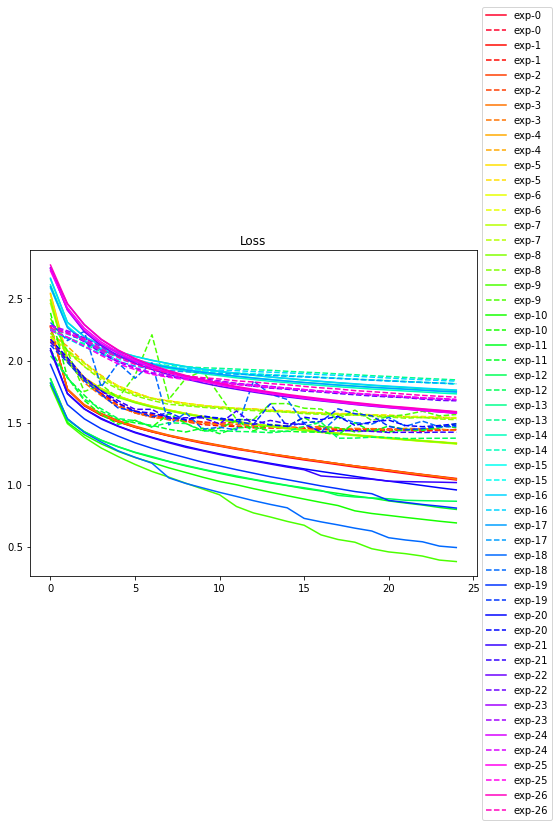

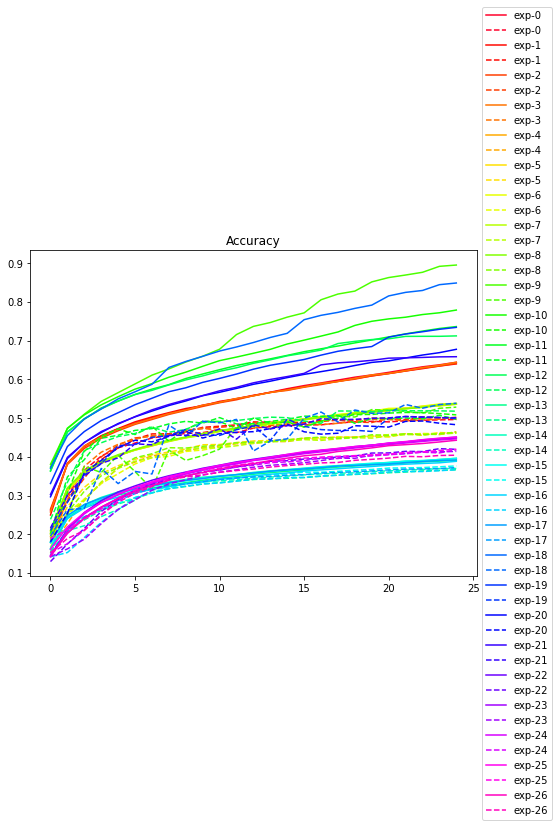

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()